# Imports

In [69]:
import pandas as pd
import numpy as np
import torch
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch

# Get Models

In [70]:
nb_path = '/media/csuser/DATA/ARTEMIS/models/NaiveBayes_yale_smote.pickle'
rf_path = '/media/csuser/DATA/ARTEMIS/models/RF_yale_smote.pickle'
nn_path = '/media/csuser/DATA/ARTEMIS/models/yale_smote'

In [71]:
nb = pickle.load(open(nb_path, 'rb'))
rf = pickle.load(open(rf_path, 'rb'))

# # yale model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    dense1 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(inputs)
    dense2 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense1)
    dense3 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense2)
    dense4 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense3)
    output = layers.Dense(units=num_classes, activation='softmax')(dense4)
    return keras.Model(inputs, output)

model = make_model(input_shape=(207), num_classes=5)

# nn model
model.load_weights(nn_path)

# Get Data

In [72]:
data = pd.read_csv("/media/csuser/DATA/ARTEMIS/yale/yale_triage_smote.csv", sep=",")

In [73]:
# Split the data into features (X) and target (y)
X = data.drop(['esi'], axis=1)
y = data['esi']

print(y.head())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(type(X_train))

0    4.0
1    2.0
2    3.0
3    3.0
4    4.0
Name: esi, dtype: float64
<class 'pandas.core.frame.DataFrame'>


# RF

In [74]:
X_test_rf = torch.tensor(X_test.values, dtype=torch.float64)
y_test_rf = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.long)

print(y_test_rf.shape)

# convert to one hot vector
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y_test_rf)
print(ohe.categories_)

y_test_rf = torch.from_numpy(ohe.transform(y_test_rf))
y_test_rf.shape

torch.Size([117852, 1])
[array([1, 2, 3, 4, 5])]


torch.Size([117852, 5])

In [75]:
y_pred_rf = rf.predict(X_test_rf.numpy())
from numpy import argmax

print(y_test_rf.shape)
print(y_pred_rf.shape)
y_test_rf = argmax(a=y_test_rf, axis=1)
y_pred_rf = argmax(a=y_pred_rf, axis=1)
print(y_test_rf)
y_pred_rf += 1
print(y_pred_rf)

torch.Size([117852, 5])
(117852, 5)
tensor([4, 4, 0,  ..., 1, 4, 1])
[1 5 1 ... 2 4 2]


In [76]:
print(type(y_pred_rf))

<class 'numpy.ndarray'>


# NN

In [77]:
X_test_nn = X_test.to_numpy().astype(np.float32)
y_test_nn = y_test.to_numpy().reshape(-1,1).astype(np.int_)

print(np.asarray(X_test_nn))

# x = tf.constant(np.asarray(x), dtype=tf.float64)
# y = tf.constant(np.asarray(y).reshape(-1, 1), dtype=tf.float64)

print(X_test_nn.shape)

# convert to one hot vector
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y_test_nn)
print(ohe.categories_)

y_test_nn = ohe.transform(y_test_nn)
y_test_nn.shape

[[0.5272631  0.13114753 0.59870297 ... 0.         0.         0.        ]
 [0.5223094  0.1452622  0.57683    ... 0.         0.         0.        ]
 [0.5455335  0.10421839 0.277688   ... 0.         0.         0.        ]
 ...
 [0.54375    0.22950819 0.9357798  ... 0.         0.         0.        ]
 [0.46875    0.13114753 0.40366971 ... 0.         0.         0.        ]
 [0.5083059  0.16393442 0.40970537 ... 0.         0.         0.        ]]
(117852, 207)
[array([1, 2, 3, 4, 5])]


(117852, 5)

In [78]:
y_pred_nn = model.predict(X_test_nn)
from numpy import argmax

print(y_test_nn.shape)
print(y_pred_nn.shape)
y_test_nn = argmax(a=y_test_nn, axis=1)
y_pred_nn = argmax(a=y_pred_nn, axis=1)
print(y_test_nn)
y_pred_nn += 1
print(y_pred_nn)

3683/3683 [==============================] - 1s 338us/step
(117852, 5)
(117852, 5)
[4 4 0 ... 1 4 1]
[5 4 1 ... 2 4 2]


In [79]:
print(type(y_pred_nn))

<class 'numpy.ndarray'>


# NB

In [80]:
y_pred_nb = nb.predict(X_test)
print(type(y_test))
print(type(y_pred_nb))
print(y_test, y_pred_nb)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
544067    5.0
552715    5.0
311793    1.0
559094    5.0
526916    5.0
         ... 
383258    1.0
193160    4.0
176775    2.0
43779     5.0
398645    2.0
Name: esi, Length: 117852, dtype: float64 [1. 5. 1. ... 1. 5. 1.]


# Take Vote

In [81]:
y_test = y_test.to_numpy()

In [82]:
print(type(y_pred_nb))
print(type(y_pred_nn))
print(type(y_pred_rf))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [83]:
y_pred = np.zeros(len(y_test))

In [84]:
from statistics import mode

# mode() takes the first value that occurs the most,
# if there are many modes. so the NN is picked in case of tie
for i in range(len(y_test)):
    y_pred[i] = mode([y_pred_nn[i], y_pred_nb[i], y_pred_rf[i]])

In [85]:
y_pred, y_test

(array([1., 5., 1., ..., 2., 4., 2.]), array([5., 5., 1., ..., 2., 5., 2.]))

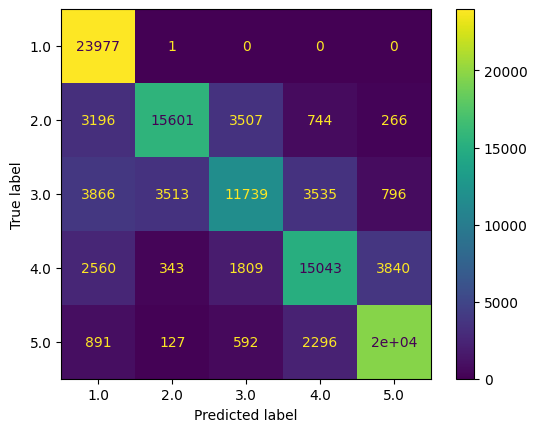

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig('/media/csuser/DATA/ARTEMIS/yale/figs/ensemble_confusion_yale_smote.png', dpi=500)

In [87]:
TP = np.zeros(5)
FP = np.zeros(5)
FN = np.zeros(5)

for i in range(5):
    for j in range(len(y_test)):
        
        if int(y_test[j]) == i+1 and int(y_pred[j]) == i+1:
            TP[i] += 1
        elif int(y_test[j]) == i+1 and int(y_pred[j]) != i+1:
            FN[i] += 1
        elif int(y_test[j]) != i+1 and int(y_pred[j]) == i+1:
            FP[i] += 1
print(TP, FN, FP)

# Precision or positive predictive value
PPV = np.zeros(5)
for i in range(5):
    if TP[i]+FP[i] != 0:
        PPV[i] = TP[i]/(TP[i]+FP[i])

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.zeros(5)
for i in range(len(TP)):
    if TP[i]+FN[i] != 0:
        TPR[i] = TP[i]/(TP[i]+FN[i])

# Overall accuracy
ACC = np.zeros(5)
class_totals = np.zeros(5)
for i in range(5):
    for j in range(len(y_test)):
        class_totals[int(y_test[j])-1] += 1
        if int(y_test[j]) == int(y_pred[j]):
            ACC[int(y_test[j])-1] += 1
ACC /= class_totals

# F1
F1 = 2 * (PPV * TPR) / (PPV + TPR)

print(PPV, TPR, F1, ACC)

[23977. 15601. 11739. 15043. 19610.] [1.000e+00 7.713e+03 1.171e+04 8.552e+03 3.906e+03] [10513.  3984.  5908.  6575.  4902.]
[0.69518701 0.79657901 0.66521222 0.69585531 0.80001632] [0.9999583  0.66916874 0.50061836 0.63755033 0.83390032] [0.82017514 0.7273363  0.57129648 0.66542808 0.81660698] [0.9999583  0.66916874 0.50061836 0.63755033 0.83390032]


In [88]:
acc = accuracy_score(y_test, y_pred)
print('Acc: ', acc)

prec = precision_score(y_test, y_pred, average='weighted')
print('Prec: ', prec)

recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: ', recall)

Acc:  0.7294742558463158
Prec:  0.7303320118447679
Recall:  0.7294742558463158
